#### This notebook contains the implementation Vision Transformer paper as  Introduced by Dosovitskiy et al. in An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. <br>
<a href = "https://arxiv.org/pdf/2010.11929v2.pdf"> Here </a> is the paper!!!

#### This implementation is in Pytorch. Same can be implemented using other libraries like tensorflow as well.

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import transforms

from sklearn.metrics import classification_report

from torchsummary import summary

#### At the core of vision transformer is the concept of Transformer. This idea was originally proposed in the paper titled "Attention is All You Need" which you can have a look at <a href = "https://arxiv.org/pdf/1706.03762.pdf">here.</a>

#### The core functionality of a "Head" is as follows : <br>
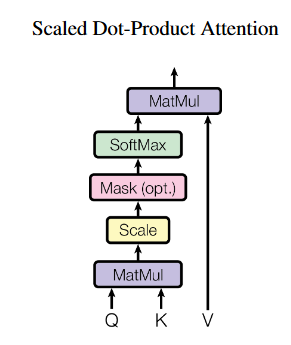

In [10]:
class Head(nn.Module):
    def __init__(self, num_heads, embedding_size):
        super(Head, self).__init__()
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        
        #Weight matrices of Q,K,V have dimensions: (embed_dim, embed_dim//no_of_heads)
        #initialize weight matrices
        self.Wq = nn.Parameter(
            torch.randn(embedding_size, self.embedding_size // self.num_heads)
        ).to(device)
        self.Wk = nn.Parameter(
            torch.randn(embedding_size, self.embedding_size // self.num_heads)
        ).to(device)
        self.Wv = nn.Parameter(
            torch.randn(embedding_size, self.embedding_size // self.num_heads)
        ).to(device)
        
    def forward(self, x):
        self.Q = torch.matmul(x, self.Wq).to(device)
        self.K = torch.matmul(x, self.Wk).to(device)
        self.V = torch.matmul(x, self.Wv).to(device)
        self.K = torch.transpose(self.K, -2, -1)
        
        self.Q = nn.LayerNorm(self.Q.size()[1:]).to(device)(self.Q)
        self.K = nn.LayerNorm(self.K.size()[1:]).to(device)(self.K)
        self.V = nn.LayerNorm(self.V.size()[1:]).to(device)(self.V)
        
        qk = torch.matmul(self.Q, self.K)
        qk = qk / np.sqrt(self.K.shape[1])
        
        # Here we are applying the softmax on the last dimension
        qk = F.softmax(qk, dim=-1)
        qkv = torch.matmul(qk, self.V)
        
        return qkv

#### In MultiHeadAttention module we use Head module to create multiple heads <br>
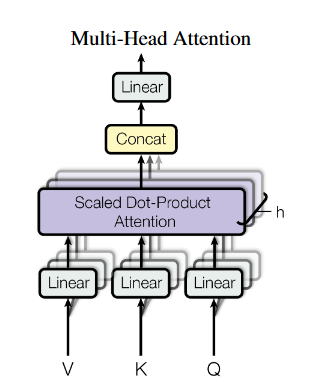

In [11]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, num_heads, embedding_size):
        super(MultiHeadedAttention, self).__init__()
        self.num_heads = num_heads
        self.embedding_size = embedding_size
        self.attention_heads = nn.ModuleList().to(device)
        
        for head_i in range(self.num_heads):
            head = Head(self.num_heads, embedding_size=self.embedding_size)
            self.attention_heads.append(head)
        self.attention_heads.to(device)
            
    def forward(self, x):
        #print('MHA x shape in forward : ', x.shape)
        
        flag=True
        for i in range(self.num_heads):
            if flag:
                out_multihead = self.attention_heads[i](x)
                flag=False
            else:
                out_multihead = torch.cat((out_multihead,self.attention_heads[i](x)),axis=2)
        
        return out_multihead

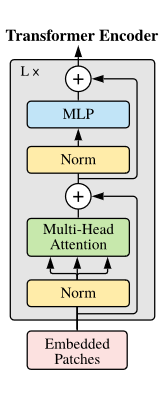

In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, batch_size, chanels, image_size, patch_size, embedding_dim, num_heads, num_layers, encoder_mlp_dim, hidden_dim):
        super(TransformerEncoder, self).__init__()
        
        self.batch_size = batch_size
        self.image_size = image_size
        self.chanels = chanels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.encoder_mlp_dim = encoder_mlp_dim
        
        self.N_patches = (self.image_size ** 2) // (self.patch_size ** 2)
        
        # Multi-Headed attention
        self.mha = MultiHeadedAttention(num_heads=num_heads, embedding_size=embedding_dim).to(device) 
        
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim*(self.N_patches + 1), out_features=2048),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(in_features=2048, out_features=embedding_dim*(self.N_patches + 1)),
            nn.GELU(),
            nn.Dropout(0.1)
        ).to(device)
        
    def forward(self, x):
        shortcut1 = x.clone() 
        #patches = get_image_patches(x)
        #print(x.shape)
        normalized_patches = nn.LayerNorm(x.size()[1:]).to(device)(x)
        #print('input to MHA ', normalized_patches.shape)
        multi_headed_op = self.mha(normalized_patches)
        #print('output of MHA ', multi_headed_op.shape)
        add_norm = shortcut1 + multi_headed_op
        shortcut2 = add_norm.clone()
        normalized_patches2 = nn.LayerNorm(add_norm.size()[1:]).to(device)(add_norm)
        
        mlp = self.mlp(normalized_patches2.reshape(
            normalized_patches2.shape[0], 
            normalized_patches2.shape[1] * normalized_patches2.shape[2])
        )
        
        #print('MLP output : ', mlp.shape)
        #print('normalized patch shape : ', normalized_patches2.shape)
        #normalized patch shape :  torch.Size([32, 50, 512])
        out = mlp + normalized_patches2.reshape(normalized_patches2.shape[0], normalized_patches2.shape[1] * normalized_patches2.shape[2])
        # MLP output :  torch.Size([32, 25600])
        # normalized patch shape :  torch.Size([32, 50, 512])
        
        return out.reshape(normalized_patches2.shape[0], normalized_patches2.shape[1], normalized_patches2.shape[2])

#### Vision transformer can have multiple encoder blocks. Each of the encoder will have the same number of heads and same size hidden MLP layers. The ViTBlock module will create multiple encoder layers and stakc them!

In [13]:
class ViTBlock(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(ViTBlock, self).__init__()
        self.encoders = nn.Sequential()
        for i in range(num_layers):
            self.encoders.append(encoder_layer)
            
    def forward(self, x):
        out = self.encoders(x)
        return out

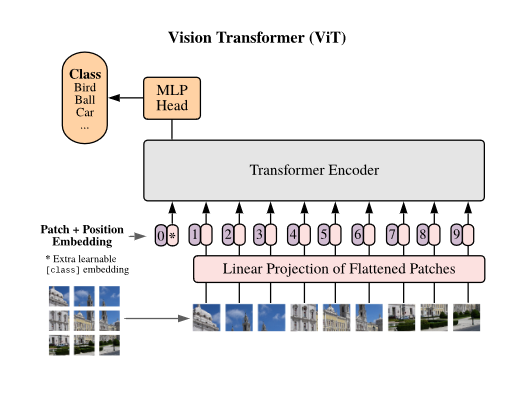

In [14]:
class VisionTransformer(nn.Module):
    def __init__(self, image, batch_size, patch_size, chanels, image_size, encoder_embedding_dim, encoder_hidden_dim, num_heads, num_layers, encoder_mlp_dim, vit_mlp_dim, num_classes):
        super(VisionTransformer, self).__init__()
        self.image = image.to(device)
        print(self.image.shape)
        self.batch_size = batch_size
        self.image.to(device)
        self.image_size = image_size
        self.encoder_embedding_dim = encoder_embedding_dim
        self.chanels = chanels
        self.N_patches = (image_size * image_size) // (patch_size ** 2)
        self.patch_size = patch_size
        self.num_classes = num_classes
        embedding_rows = self.patch_size ** 2 
        embedding_cols = encoder_embedding_dim
        print('cols : ', str(embedding_cols))
        
        self.conv = nn.Conv2d(
            in_channels=self.chanels, 
            kernel_size=self.patch_size, 
            stride=self.patch_size, 
            out_channels=self.encoder_embedding_dim
        ).to(device)
        
        self.positional_embeddings = nn.Parameter(torch.randn(self.N_patches, encoder_embedding_dim)).to(device)
        
        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_cols)).to(device)
        #self.embedding_matrix = nn.Parameter(torch.randn(embedding_cols, embedding_rows))
        
        encoder = TransformerEncoder(
            batch_size = batch_size,
            chanels=chanels,
            image_size=image_size,
            patch_size=patch_size,
            embedding_dim=encoder_embedding_dim,
            encoder_mlp_dim=encoder_mlp_dim, 
            hidden_dim=encoder_hidden_dim, 
            num_heads=num_heads,
            num_layers=num_layers
        ).to(device)
        self.encoder = ViTBlock(encoder, num_layers)
        self.encoder.to(device)
        self.mlp = nn.Linear(in_features=self.encoder_embedding_dim, out_features=self.num_classes)
        #self.mlp =nn.Sequential(
        #    nn.Linear(in_features=encoder_embedding_dim, out_features=vit_mlp_dim),
        #    nn.GELU(),
        #    nn.Linear(in_features=vit_mlp_dim, out_features=num_classes),
        #    nn.GELU()
        #).to(device)
        
    def forward(self, x):
        #print('Input Image : ', x.shape)
        patches = self.conv(x)
        
        embedded_patches = patches.flatten(2).transpose(1, 2)
        #print('shape of patches : ', embedded_patches.shape)
        unsq = self.positional_embeddings.unsqueeze(0).expand(embedded_patches.shape[0], -1, -1)
        
        
        #patches size shape :  torch.Size([32, 512, 7, 7])
        #embedded_patches shape :  torch.Size([32, 49, 512])
        #unsqueeze expand shape:  torch.Size([32, 49, 512])
        
        #print('patches size shape : ', patches.shape)
        #print('embedded_patches shape : ', embedded_patches.shape)
        #print('unsqueeze expand shape: ', unsq.shape)
        
        embedded_patches_with_pos_emb = embedded_patches +  unsq
        #print('After pos emb : ', embedded_patches_with_pos_emb.shape)
        
        class_token = self.class_token.repeat(embedded_patches.shape[0], 1, 1)
        with_class_token = torch.cat([embedded_patches_with_pos_emb, class_token], dim=1)
        #print('with cls token : ', with_class_token.shape)
        encoded = self.encoder(with_class_token)
        #print('shape of encoded passed : ', encoded.shape)
        #print('shape of encoded expect : ', self.encoder_embedding_dim)
        
        output = self.mlp(encoded[:,0,:])

        return output

#### Now that we have the architecutre of ViT at hand, we can try it out on simple MNIST dataset. The important thing to note about this is that MNIST dataset has images of dimensions 28*28*1, where height and width of image is 28 and they have only 1 color chanel.

In [3]:
from torchvision import datasets
mnist_train = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

mnist_test = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [32]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
print('Training batches : ', len(train_loader))
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=32, shuffle=True)
print('Validation batches : ', len(test_loader))

Training batches :  1875
Validation batches :  313


In [33]:
test_image = torch.stack([mnist_test[0][0], mnist_test[1][0], mnist_test[2][0], mnist_test[3][0]], dim=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running torch on : ', device)

Running torch on :  cuda


In [9]:
def plot(test_image, patch_size):
    patches = get_image_patches(test_image, patch_size=4)
    print(patches.shape)

    first_image = patches[0]
    print(first_image.shape)

    fig = plt.figure(figsize=(12, 12))
    for idx in range(first_image.shape[0]):
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        patch = first_image[idx]
        plt.imshow(patch.T)
        
    plt.show()

In [15]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [16]:
# Display image and label.

def visualize(loader):
    train_features, train_labels = next(iter(train_loader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img.T)
    plt.show()
    print(f"Label: {label}")

In [19]:
def train(model, criterion, optimizer, epochs, train_loader, test_loader): # Added train_loader and test_loader to experiment
    train_losses = []
    val_losses = []

    train_accuracies = []
    test_accuracies = []

    best_accuracy = 0.0
    model.to(device)
    print("Begin training...")
    for epoch in range(1, epochs + 1):
        running_train_loss = 0.0
        running_accuracy = 0.0
        running_vall_loss = 0.0
        total = 0

        # Training Loop
        for data in train_loader:
        #for data in enumerate(train_loader, 0):
            inputs, outputs = data  # get the input and real species as outputs; data is a list of [inputs, outputs]
            #inputs = inputs.reshape(-1, 28 * 28)
            outputs = outputs.type(torch.LongTensor)
            outputs = outputs.long()
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            predicted_outputs = model(inputs)   # predict output from the model
            train_loss = criterion(predicted_outputs, outputs)   # calculate loss for the predicted output

            _, predicted = torch.max(predicted_outputs, 1)
            running_vall_loss += train_loss.item()
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()


            optimizer.zero_grad()   # zero the parameter gradients
            train_loss.backward()   # backpropagate the loss
            optimizer.step()        # adjust parameters based on the calculated gradients
            running_train_loss += train_loss.item()  # track the loss value
        accuracy = (100 * running_accuracy / total)

        train_accuracies.append(accuracy)
        # Calculate training loss value
        train_loss_value = running_train_loss/len(train_loader)

        # Validation Loop
        actual_labels = []
        predicted_labels = []
        running_vall_loss = 0.0
        with torch.no_grad():
            model.eval()
            for data in test_loader:
                inputs, outputs = data
                outputs = outputs.type(torch.LongTensor)

                #model.to(device)
                inputs = inputs.to(device)
                outputs = outputs.to(device)
                outputs = outputs.long()

                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, outputs)
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs, 1)

                actual_labels.append(outputs.cpu().numpy())
                predicted_labels.append(predicted.cpu().numpy())
                #print(outputs, predicted)

                running_vall_loss += val_loss.item()
                total += outputs.size(0)
                running_accuracy += (predicted == outputs).sum().item()
        # Calculate validation loss value
        val_loss_value = running_vall_loss/len(test_loader)

        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.
        accuracy = (100 * running_accuracy / total)

        # Save the model if the accuracy is the best
        if accuracy > best_accuracy:
            #saveModel()
            best_accuracy = accuracy

        # Print the statistics of the epoch
        print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %.4f %%' % (accuracy))
        #print(classification_report(actual_labels, predicted_labels))
        train_losses.append(train_loss_value)
        val_losses.append(val_loss_value)
        test_accuracies.append(accuracy)

    return model, train_losses, val_losses, train_accuracies, test_accuracies

In [20]:
def evaluate_model(model, test_loader):
    actual_labels = []
    predicted_labels = []
    running_val_loss = 0.0
    total = 0.0
    running_accuracy = 0.0

    with torch.no_grad():
        model.eval()
        for data in test_loader:
            inputs, outputs = data
            outputs = outputs.type(torch.LongTensor)

            model.to(device)
            inputs = inputs.to(device)
            outputs = outputs.to(device)

            predicted_outputs = model(inputs)
            val_loss = criterion(predicted_outputs, outputs)
            # The label with the highest value will be our prediction
            _, predicted = torch.max(predicted_outputs, 1)

            actual_labels.append(outputs.cpu().numpy())
            predicted_labels.append(predicted.cpu().numpy())
            #print(outputs, predicted)

            running_val_loss += val_loss.item()
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()
    print('Validation Accuracy : ', (running_accuracy / total) * 100, ' Validation loss : ', running_val_loss / len(test_loader))
    return actual_labels, predicted_labels

In [21]:
def get_classification_report(model, test_loader):
    actual_labels, predicted_labels = evaluate_model(model, test_loader)

    y_test = []
    for array in actual_labels:
        for item in array:
            y_test.append(item)

    y_pred = []
    for array in predicted_labels:
        for item in array:
            y_pred.append(item)

    print(classification_report(y_test, y_pred))

In [25]:
model = VisionTransformer(
    image=test_image,
    batch_size=32,
    image_size=28, 
    chanels=1,
    patch_size=4,
    encoder_embedding_dim=512,
    encoder_hidden_dim=128,
    num_heads=8,
    num_layers=1,
    encoder_mlp_dim=128 * 4,
    vit_mlp_dim=128 * 4,
    num_classes=10
)
model.to(device)

import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


print(model)
print(get_n_params(model))

torch.Size([4, 1, 28, 28])
cols :  512
VisionTransformer(
  (conv): Conv2d(1, 512, kernel_size=(4, 4), stride=(4, 4))
  (encoder): ViTBlock(
    (encoders): Sequential(
      (0): TransformerEncoder(
        (mha): MultiHeadedAttention(
          (attention_heads): ModuleList(
            (0): Head()
            (1): Head()
            (2): Head()
            (3): Head()
            (4): Head()
            (5): Head()
            (6): Head()
            (7): Head()
          )
        )
        (mlp): Sequential(
          (0): Linear(in_features=25600, out_features=2048, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=2048, out_features=25600, bias=True)
          (4): GELU(approximate='none')
          (5): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (mlp): Linear(in_features=512, out_features=10, bias=True)
)
104899082


In [26]:
#summary(model, (1, 28, 28))

In [28]:
#104899082
model, train_losses, val_losses, train_acc, val_acc = train(model, criterion, optimizer, epochs=10, train_loader=train_loader, test_loader=test_loader)

Begin training...
Completed training batch 1 Training Loss is: 0.1990 Validation Loss is: 0.1388 Accuracy is 94.0343 %
Completed training batch 2 Training Loss is: 0.1441 Validation Loss is: 0.1276 Accuracy is 95.5371 %
Completed training batch 3 Training Loss is: 0.1131 Validation Loss is: 0.1715 Accuracy is 96.1329 %
Completed training batch 4 Training Loss is: 0.0956 Validation Loss is: 0.1043 Accuracy is 96.9229 %
Completed training batch 5 Training Loss is: 0.0801 Validation Loss is: 0.0933 Accuracy is 97.3871 %
Completed training batch 6 Training Loss is: 0.0695 Validation Loss is: 0.0834 Accuracy is 97.6986 %
Completed training batch 7 Training Loss is: 0.0598 Validation Loss is: 0.0995 Accuracy is 97.8657 %
Completed training batch 8 Training Loss is: 0.0523 Validation Loss is: 0.0624 Accuracy is 98.2571 %
Completed training batch 9 Training Loss is: 0.0449 Validation Loss is: 0.0710 Accuracy is 98.3771 %
Completed training batch 10 Training Loss is: 0.0393 Validation Loss is: 

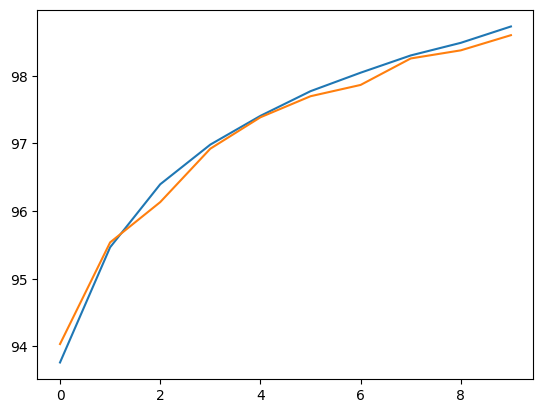

In [29]:
plt.plot(train_acc)
plt.plot(val_acc)

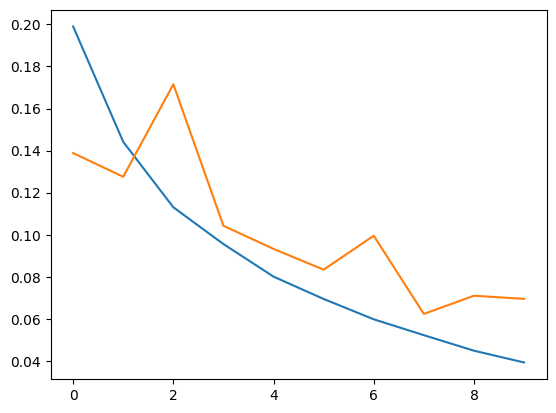

In [30]:
plt.plot(train_losses)
plt.plot(val_losses)

In [31]:
get_classification_report(model, test_loader)

Validation Accuracy :  97.83  Validation loss :  0.06953875663469526
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.96      0.97      1010
           4       0.96      0.99      0.97       982
           5       0.96      0.99      0.97       892
           6       0.98      0.99      0.98       958
           7       0.95      0.98      0.97      1028
           8       0.99      0.96      0.98       974
           9       0.99      0.95      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

